In [231]:
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy.optimize import curve_fit
import time
import matplotlib.colors as colors
import matplotlib.pylab as pl
import matplotlib as mpl
import seaborn as sns
from matplotlib.lines import Line2D

import scipy.interpolate as interp


In [232]:
#Metode

#Metoda Runge-Kutta 4. reda

def rk4( f, x0, t ):
    n = len( t )
    x = np.array( [ x0 ] * n )
    for i in range( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( x[i], t[i] )
        k2 = h * f( x[i] + 0.5 * k1, t[i] + 0.5 * h )
        k3 = h * f( x[i] + 0.5 * k2, t[i] + 0.5 * h )
        k4 = h * f( x[i] + k3, t[i+1] )
        x[i+1] = x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0

    return x


#Strelska metoda

def shoot( f, a, b, z1, z2, t, tol ):
    max_iter = 25   # Maximum number of shooting iterations

    n = len( t )    # Determine the size of the arrays we will generate

    # Compute solution to first initial value problem (IVP) with y'(a) = z1.
    # Because we are using the secant method to refine our estimates of z =
    # y', we don't really need all the solution of the IVP, just the last
    # point of it -- this is saved in w1.

    y = rk4( f, [a,z1], t )
    w1 = y[n-1,0]
    
    print ("%2d: z = %10.3e, error = %10.3e" % ( 0, z1, b - w1 ))

    # Begin the main loop.  We will compute the solution of a second IVP and
    # then use the both solutions to refine our estimate of y'(a).  This
    # second solution then replaces the first and a new "second" solution is
    # generated.  This process continues until we either solve the problem to
    # within the specified tolerance or we exceed the maximum number of
    # allowable iterations.

    for i in range( max_iter ):

        # Solve second initial value problem, using y'(a) = z2.  We need to
        # retain the entire solution vector y since if y(t(n)) is close enough
        # to b for us to stop then the first column of y becomes our solution
        # vector.

        y = rk4( f, [a,z2], t )
        w2 = y[n-1,0]

        print ("%2d: z = %10.3e, error = %10.3e" % ( i+1, z2, b - w2 ))

        # Check to see if we are done...

        if abs( b - w2 ) < tol:
            break

        # Compute the new approximations to the initial value of the first
        # derivative.  We compute z2 using a linear fit through (z1,w1) and
        # (z2,w2) where w1 and w2 are the estimates at t=b of the initial
        # value problems solved above with y1'(a) = z1 and y2'(a) = z2.  The
        # new value for z1 is the old value of z2.

        #z1, z2 = ( z2, z1 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w1 ) )
        z1, z2 = ( z2, z2 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w2 ) )
        w1 = w2

    # All done.  Check to see if we really solved the problem, and then return
    # the solution.

    if abs( b - w2 ) >= tol:
        print ("\a**** ERROR ****")
        print ("Maximum number of iterations (%d) exceeded" % max_iter)
        print ("Returned values may not have desired accuracy")
        print ("Error estimate of returned solution is %e" % ( b - w2 ))

    return y[:,0]


#Diferenčna metoda

def fd( u, v, w, t, a, b ):
    # Get the dimension of t and make sure that t is an n-element vector

    if type( t ) != np.ndarray:
        if type( t ) == list:
            t = np.array( t )
        else:
            t = np.array( [ float( t ) ] )

    n = len( t )

    # Make sure that u, v, and w are either scalars or n-element vectors.
    # If they are scalars then we create vectors with the scalar value in
    # each position.

    if type( u ) == int or type( u ) == float:
        u = np.array( [ float( u ) ] * n )

    if type( v ) == int or type( v ) == float:
        v = np.array( [ float( v ) ] * n )

    if type( w ) == int or type( w ) == float:
        w = np.array( [ float( w ) ] * n )

    # Compute the stepsize.  It is assumed that all elements in t are
    # equally spaced.

    h = t[1] - t[0]

    # Construct tridiagonal system; boundary conditions appear as first and
    # last equations in system.

    A = -( 1.0 + w[1:n] * h / 2.0 )
    A[-1] = 0.0

    C = -( 1.0 - w[0:n-1] * h / 2.0 )
    C[0] = 0.0

    D = 2.0 + h * h * v
    D[0] = D[n-1] = 1.0

    B = - h * h * u
    B[0] = a
    B[n-1] = b

    # Solve tridiagonal system

    for i in range( 1, n ):
        xmult = A[i-1] / D[i-1]
        D[i] = D[i] - xmult * C[i-1]
        B[i] = B[i] - xmult * B[i-1]

    x = np.zeros( n )
    x[n-1] = B[n-1] / D[n-1]

    for i in range( n - 2, -1, -1 ):
        x[i] = ( B[i] - C[i] * x[i+1] ) / D[i]

    return x

In [239]:
def schrodinger(y, k):
    return np.array([y[1], -k**2 * y[0]])

def interpolacija(k, k_vred, rob_vred):
    interpolator = interp.interp1d(k_vred, rob_vred)
    return interpolator(k)

def robne_vrednosti_racunanje(k_vred, n):
    rob_vred = np.ones_like(k_vred)
    t = np.linspace(0, 1, n)  

    for i, k in enumerate(k_vred):
        def f(y, t):
            return schrodinger(y, k)
        
        y = rk4(f, [0., 1.], t)
        rob_vred[i] = y[-1, 0]  
    return rob_vred

def normaliziracija(arr, x):
    normal = []
    for e in arr:
        integral = np.trapz(e**2, x)
        if integral != 0:
            normal.append(e / np.sqrt(integral))
        else:
            normal.append(e)
    return np.array(normal)

def anal_neskoncna_jama(x, n):
    return np.sin(n * np.pi * (x + 0.5))

def lastne_funkcije_strel(k_nicle, n):
    x1 = np.linspace(-0.5, 0.5, n)  
    l_funk = []

    for k in k_nicle:
        def f(y, x):
            return schrodinger(y, k)
        
        zac_pogoji = [0.0, 1.0]
        
        l_funkcija = rk4(f, zac_pogoji, x1)[:, 0]  
        l_funkcija /= np.max(np.abs(l_funkcija))
        l_funk.append(l_funkcija)

    return l_funk, x1

def diferencna_metoda(t):
    N = len(t)
    h = np.abs(t[1] - t[0])
    matrika = gen_matrix(N, h)
    l_vred, l_vekt = np.linalg.eigh(matrika)
    l_vekt = l_vekt.T
    l_vred = l_vred / l_vred[0]
    
    l_vekt_norm = []
    for vekt in l_vekt:
        abs_vekt = np.abs(vekt)
        smer = 1
        norm_vekt = []
        for i in range(1, N - 3):
            if abs_vekt[i-1] > abs_vekt[i] and abs_vekt[i] < abs_vekt[i+1] and vekt[i] < 0:
                smer *= -1
            norm_vekt.append(abs_vekt[i] * smer)
            if abs_vekt[i-1] > abs_vekt[i] and abs_vekt[i] < abs_vekt[i+1] and vekt[i] > 0:
                smer *= -1
        l_vekt_norm.append(norm_vekt / max(norm_vekt))

    return l_vekt_norm, l_vred

/tmp/ipykernel_606198/2091994542.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(smap, label='Energija')


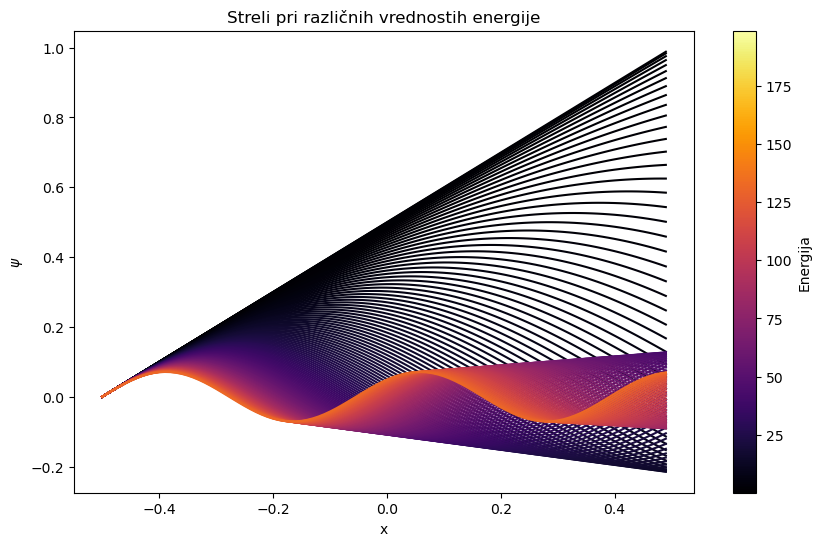

In [240]:
def val_funk():
    dx = 1e-2  
    dk = 0.1   
    k_vred = np.arange(0.1, np.sqrt(200), dk)  
    a = 1
    x = np.arange(-a/2, a/2, dx)  
    resitve = []

    plt.figure(figsize=(10, 6))

    for k in k_vred:
        x0 = 0.0
        v0 = 1.0
        zac_pogoji = [x0, v0]  
        
        def f(y, x):
            return schrodinger(y, k)
        
        psi = rk4(f, zac_pogoji, x)
        resitve.append(psi[:, 0][-1])  
        
        plt.plot(x, psi[:, 0], color=mpl.cm.inferno(k**2 / 300))

    smap = mpl.cm.ScalarMappable(cmap='inferno')
    smap.set_array(k_vred**2)  
    plt.colorbar(smap, label='Energija')
    plt.xlabel('x')
    plt.ylabel(r'$\psi$')
    plt.title('Streli pri različnih vrednostih energije')
    plt.savefig('Streli pri različnih vrednostih energije')
    plt.show()

val_funk()

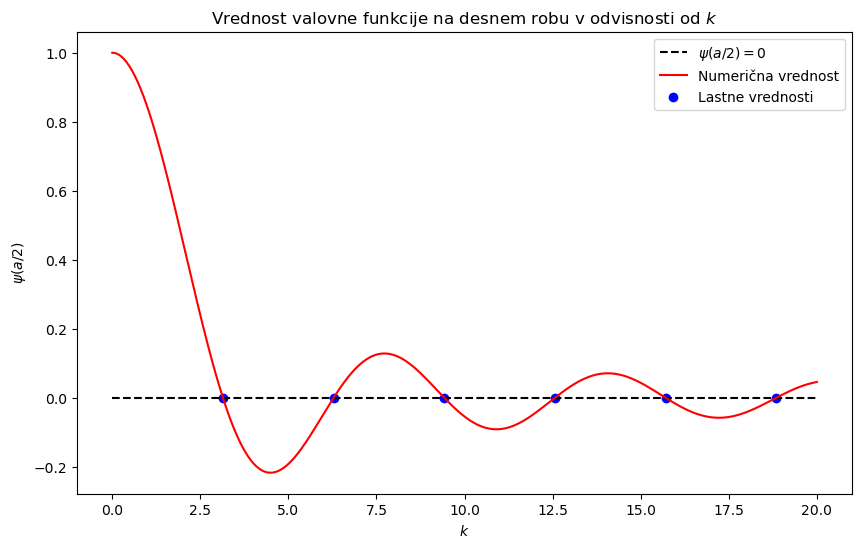

In [235]:
n = 500
k_vred = np.linspace(0, 20, n)  

rob_vred = robne_vrednosti_racunanje(k_vred, n)

nicle = np.where(np.diff(np.sign(rob_vred)))[0]

k_nicle = np.array([])
for i in nicle:
    k_nicla = opt.brentq(interpolacija, k_vred[i], k_vred[i+1], args=(k_vred, rob_vred))
    k_nicle = np.append(k_nicle, k_nicla)

plt.figure(figsize=(10, 6))
plt.hlines(0, 0, 20, linestyles='dashed', colors='black', label='$\psi(a/2) = 0$')
plt.plot(k_vred, rob_vred, color='red', label='Numerična vrednost')

plt.scatter(k_nicle, np.zeros_like(k_nicle), color='blue', label='Lastne vrednosti')

plt.xlabel('$k$')
plt.ylabel('$\psi(a/2)$')
plt.title('Vrednost valovne funkcije na desnem robu v odvisnosti od $k$')
plt.legend()
plt.savefig('desen rob')
plt.show()

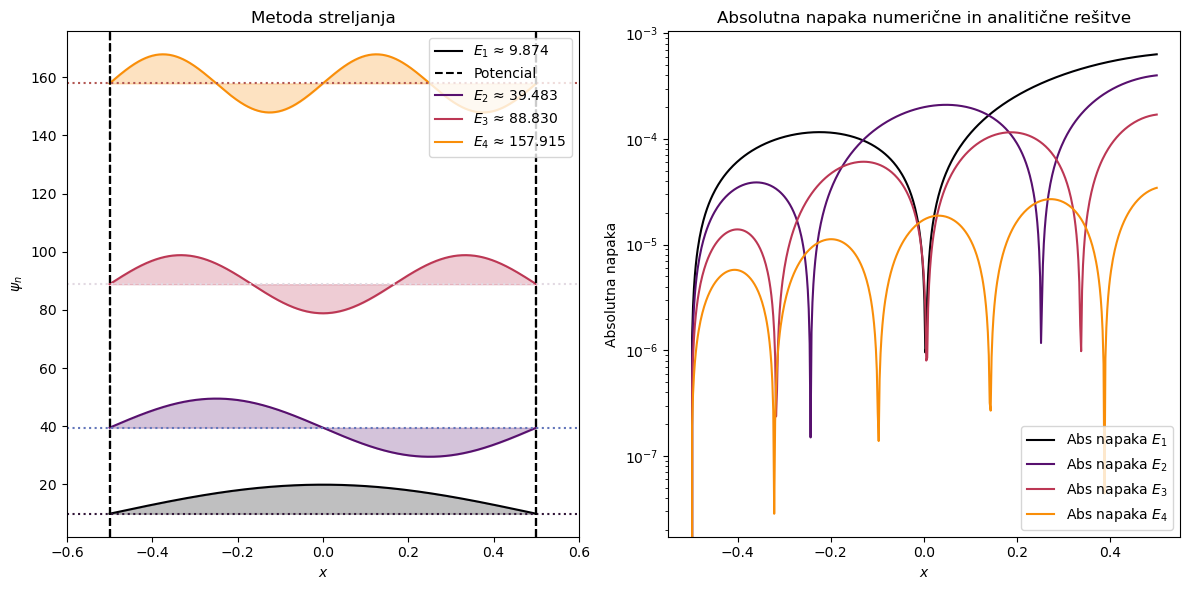

In [236]:
n = 200
k_vred = np.linspace(0, 20, n)  

rob_vred = robne_vrednosti_racunanje(k_vred, n)

nicle = np.where(np.diff(np.sign(rob_vred)))[0]

k_nicle = np.array([])
for i in nicle:
    k_nicla = opt.brentq(interpolacija, k_vred[i], k_vred[i+1], args=(k_vred, rob_vred))
    k_nicle = np.append(k_nicle, k_nicla)

lastne_funkcije, x1 = lastne_funkcije_strel(k_nicle, 500)

plt.figure(figsize=(12, 6))

# graf last vred
plt.subplot(1, 2, 1)
scaling_factor = 10  
for i in range(4):
    En = f'$E_{{{i + 1}}}$'

    plt.plot(x1, scaling_factor * lastne_funkcije[i] + k_nicle[i]**2, label=f'{En} ≈ {k_nicle[i]**2:.3f}', color=plt.cm.inferno(i / 4))
    plt.fill_between(x1, k_nicle[i]**2, scaling_factor * lastne_funkcije[i] + k_nicle[i]**2, alpha=0.25, color=plt.cm.inferno(i / 4))
    plt.axhline(k_nicle[i]**2, linestyle='dotted', color=plt.cm.twilight_shifted(i / 4))
    plt.axvline(-0.5, color='black', linestyle='--', label='Potencial' if i == 0 else "")
    plt.axvline(0.5, color='black', linestyle='--')

plt.xlabel('$x$')
plt.ylabel(r'$\psi_n$')
plt.xlim(-0.6, 0.6)
plt.title('Metoda streljanja')
plt.legend()

# abs error graf
plt.subplot(1, 2, 2)
for i in range(4):
    # Analiticna res
    anal = anal_neskoncna_jama(x1, i + 1)
    # Abs error
    absolutna_napaka = np.abs(anal - lastne_funkcije[i])
    plt.plot(x1, absolutna_napaka, label=f'Abs napaka $E_{{{i + 1}}}$', color=plt.cm.inferno(i / 4))

plt.xlabel('$x$')
plt.ylabel('Absolutna napaka')
plt.yscale('log')  
plt.title('Absolutna napaka numerične in analitične rešitve')
plt.legend()

plt.tight_layout()
plt.savefig('strel')
plt.show()



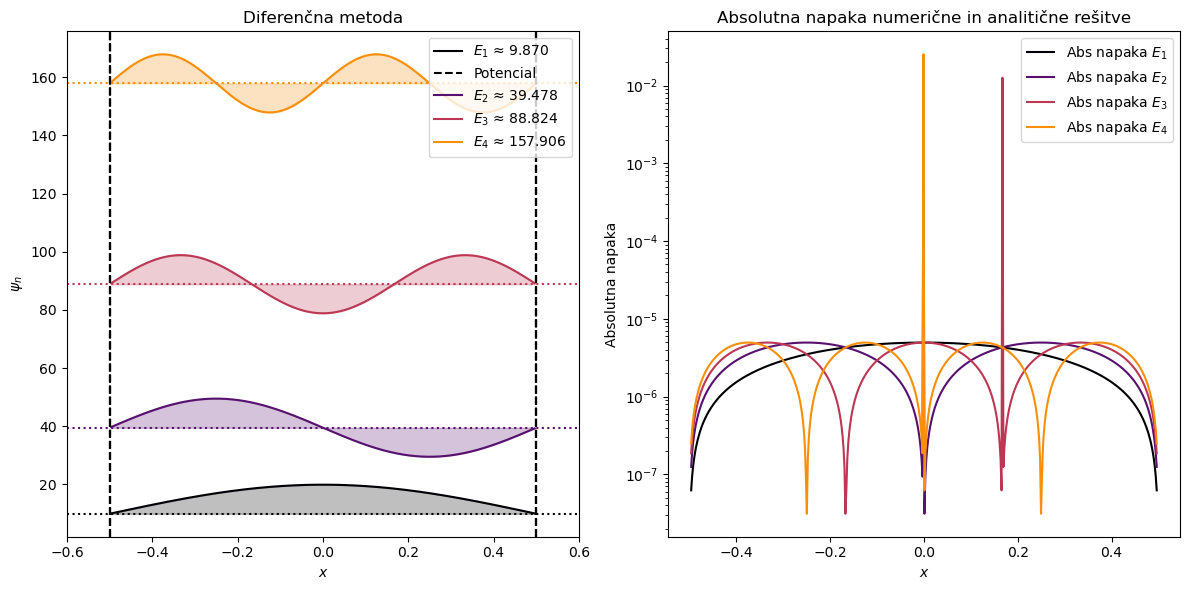

In [237]:
n = 500  
t = np.linspace(-0.5, 0.5, n)  
l_vekt_norm, l_vred = diferencna_metoda(t)
l_vred = l_vred * np.pi**2

plt.figure(figsize=(12, 6))

# graf last funk
plt.subplot(1, 2, 1)
scaling_factor = 10  
for i in range(4):
    En = f'$E_{{{i + 1}}}$'

    plt.plot(t[2:-2], scaling_factor * np.array(l_vekt_norm[i]) + np.sqrt(l_vred[i])**2, label=f'{En} ≈ {l_vred[i]:.3f}', color=plt.cm.inferno(i / 4))
    plt.fill_between(t[2:-2], np.sqrt(l_vred[i])**2, scaling_factor * np.array(l_vekt_norm[i]) + np.sqrt(l_vred[i])**2, alpha=0.25, color=plt.cm.inferno(i / 4))
    plt.axhline(np.sqrt(l_vred[i])**2, linestyle='dotted', color=plt.cm.inferno(i / 4))
    plt.axvline(-0.5, color='black', linestyle='--', label='Potencial' if i == 0 else "")
    plt.axvline(0.5, color='black', linestyle='--')

plt.xlabel('$x$')
plt.ylabel(r'$\psi_n$')
plt.xlim(-0.6, 0.6)
plt.title('Diferenčna metoda')
plt.legend()

# graf abs napake
plt.subplot(1, 2, 2)
for i in range(4):
    # Anal resitev
    anal = anal_neskoncna_jama(t[2:-2], i + 1)
    norm_l_vekt = l_vekt_norm[i] / np.max(np.abs(l_vekt_norm[i]))
    # Abs terror he he
    absolutna_napaka = np.abs(anal - norm_l_vekt)
    plt.plot(t[2:-2], absolutna_napaka, label=f'Abs napaka $E_{{{i + 1}}}$', color=plt.cm.inferno(i / 4))

plt.xlabel('$x$')
plt.ylabel('Absolutna napaka')
plt.title('Absolutna napaka numerične in analitične rešitve')
plt.legend()
plt.yscale('log') 
plt.grid(False)  

plt.savefig('diferencna metoda')
plt.tight_layout()
plt.show()



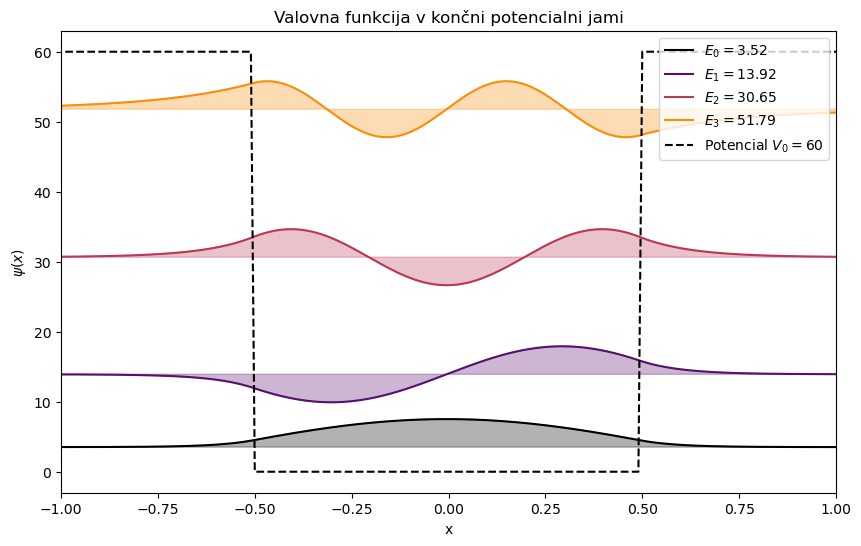

In [241]:
#koncna potencialna jama
def V_pot(x, V0, a):
    return np.where(np.abs(x) > a/2, V0, 0)

def koncna_dif(V0, dx=1e-2):
    a = 1
    x = np.arange(-2 * a, 2 * a, dx)  
    N = len(x)
    
    T = np.zeros((N - 2, N - 2))
    for i in range(N - 2):
        for j in range(N - 2):
            if i == j:
                T[i, j] = -2
            elif np.abs(i - j) == 1:
                T[i, j] = 1
    
    H = -T / (2 * dx ** 2)  
    V = np.zeros((N - 2, N - 2))

    for i in range(N - 2):
        V[i, i] = V_pot(x[i + 1], V0, a)
    
    H_tot = H + np.diag(V.diagonal())  

    l_vred, l_vekt = np.linalg.eigh(H_tot)
    indeksi_2 = np.argsort(l_vred)

    psi = []
    for i in range(4):  
        vekt = l_vekt[:, indeksi_2[i]]
        vekt = np.insert(vekt, 0, 0)
        vekt = np.append(vekt, 0)
        psi.append(vekt / np.max(np.abs(vekt)))

    energije = l_vred[indeksi_2[:4]]  
    return x, psi, energije

def koncna_potencialna_jama(V0):
    x, psi, E = koncna_dif(V0)
    scaling_factor = 4  
    
    plt.figure(figsize=(10, 6))
    
    for i, p in enumerate(psi):
        plt.plot(x, scaling_factor * p + E[i], label=f'$E_{i} = {E[i]:.2f}$', color=plt.cm.inferno(i / 4))
        plt.fill_between(x, E[i], scaling_factor * p + E[i], alpha=0.3, color=plt.cm.inferno(i / 4))

    plt.plot(x, V_pot(x, V0, 1), color='black', linestyle='--', label='Potencial $V_0 = 60$')
    plt.xlabel('x')
    plt.xlim(-1, 1)
    plt.ylabel(r'$\psi(x)$')
    plt.title('Valovna funkcija v končni potencialni jami')
    plt.legend(loc='upper right')
    plt.savefig('Končna')
    plt.show()

koncna_potencialna_jama(60)

